In [2]:
from rdkit import Chem
import numpy as np
from rdkit.Chem import DataStructs, rdMolDescriptors, rdFingerprintGenerator, SDWriter
import random
from rdkit.Chem import Draw


# Liczymy podobieństwa inhibitorów

Zapisane w kolejności:
- **avibactam**: NC(=O)[C@@H]1CC[C@@H]2CN1C(=O)N2OS(=O)(=O)O
- **imipenem**: C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(SCCNC=N)C[C@H]12
- **meropenem**: C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[C@H](C(=O)N(C)C)C3)[C@H](C)[C@H]12


In [3]:
#inhibitory w smiles
inhibitor_smiles = [
    "NC(=O)[C@@H]1CC[C@@H]2CN1C(=O)N2OS(=O)(=O)O",
    "C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(SCCNC=N)C[C@H]12",
    "C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[C@H](C(=O)N(C)C)C3)[C@H](C)[C@H]12"
]

inhibitors = [Chem.MolFromSmiles(smiles) for smiles in inhibitor_smiles]

# Wczytaj fingerprinty inhibitorów przy użyciu MACCS
inhibitor_fps = [rdMolDescriptors.GetMACCSKeysFingerprint(mol) for mol in inhibitors]

similarity_matrix = np.zeros((len(inhibitor_fps), len(inhibitor_fps)))

for i in range(len(inhibitor_fps)):
    for j in range(i, len(inhibitor_fps)):  
        similarity = DataStructs.TanimotoSimilarity(inhibitor_fps[i], inhibitor_fps[j])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity 

print("Macierz podobieństwa między inhibitorami:")
for i in range(len(inhibitor_smiles)):
    for j in range(len(inhibitor_smiles)):
        print(f"{similarity_matrix[i, j]:.3f}", end="\t")
    print()


Macierz podobieństwa między inhibitorami:
1.000	0.462	0.440	
0.462	1.000	0.768	
0.440	0.768	1.000	


Widzimy, że imipenem i meropenem są do sienie bardziej podobne (0.768), niż do avibactamu (około 0.4).

# Łączenie biblioteki potencjalnych związków
Kolejne pliki zawierają związki podobne do:
- CC(C)(O/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[n+]3ccccc3)CS[C@H]12)c1csc(N)n1)C(=O)O
- CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N+]3(C)CCCC3)CS[C@H]12)c1csc(N)n1
- Nc1nc(/C(=N/O)C(=O)N[C@@H]2C(=O)N3C(C(=O)O)=C(/C=C4\CCN([C@@H]5CCNC5)C4=O)CS[C@H]23)ns1

W dwóch pierwszych po około 2000 związków, a w ostatnim 600.

Wynikowo dostajemy 2260 związków zapisanych w pliku 'polaczone_bialka_3D.sdf'.

In [4]:
# Generator fingerprintów Morgana z radius=3
gen = rdFingerprintGenerator.GetMorganGenerator(radius=3)

# Wczytaj pliki SDF 3D
sdf_files = ["compounds_3D\plik1.sdf", "compounds_3D\plik2.sdf", "compounds_3D\plik3.sdf"]
all_molecules = []
seen_fps = set()

# Wczytaj cząsteczki z plików SDF
for sdf_file in sdf_files:
    supplier = Chem.SDMolSupplier(sdf_file)
    for mol in supplier:
        if mol is not None:
            fp = gen.GetFingerprint(mol)  # Generowanie fingerprintu Morgana
            fp_bytes = fp.ToBinary()  # Konwersja fingerprintu do bajtów (porównywanie)

            # Sprawdzanie, czy fingerprint już występuje
            if fp_bytes not in seen_fps:
                seen_fps.add(fp_bytes)
                all_molecules.append(mol)

# Zapisywanie unikalnych cząsteczek do nowego pliku SDF
output_writer = SDWriter("polaczone_bialka_3D.sdf")
for mol in all_molecules:
    output_writer.write(mol)
output_writer.close()

print(f"Połączono i zapisano {len(all_molecules)} unikalnych cząsteczek do pliku 'polaczone_bialka_3D.sdf'")

Połączono i zapisano 2260 unikalnych cząsteczek do pliku 'polaczone_bialka_3D.sdf'


# Przykładowe związki

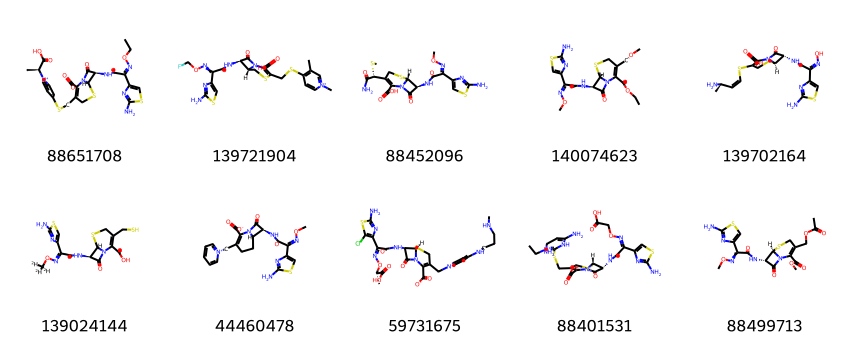

In [5]:
supplier = Chem.SDMolSupplier("polaczone_bialka_3D.sdf")
no_none=[mol for mol in supplier if mol]
[Chem.SanitizeMol(mol) for mol in no_none]
random_mols = random.sample(no_none, min(10, len(no_none)))
Draw.MolsToGridImage(random_mols, molsPerRow=5,subImgSize=(170,170),legends=[mol.GetProp('_Name') for mol in random_mols],maxMols=100)

# Sprawdzanie podobieństw związków
Z pliku 'polaczone_bialka_3D.sdf' sprawdzamy ich podobieństwa do naszych inhibitorów. Ma to nam ułatwić wybór struktury krystalicznej KPC-2.
Manipulując wyborem prawdopodobieństw tylko większych od danej wartości możemy sprawdzić ile jest związków bardzo podobnych. (np.where)

In [6]:
def calculate_similarity(sim_val, protein_sdf="polaczone_bialka_3D.sdf"):
    proteins = Chem.SDMolSupplier(protein_sdf)

    inhibitors = {
        "avibactam": "NC(=O)[C@@H]1CC[C@@H]2CN1C(=O)N2OS(=O)(=O)O",
        "imipenem": "C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(SCCNC=N)C[C@H]12",
        "meropenem": "C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[C@H](C(=O)N(C)C)C3)[C@H](C)[C@H]12"
    }

    inhibitor_mols = {name: Chem.MolFromSmiles(smiles) for name, smiles in inhibitors.items()}

    # Fingerprinty inhibitorów
    inhibitor_fps = {name: rdMolDescriptors.GetMACCSKeysFingerprint(mol) for name, mol in inhibitor_mols.items()}
    protein_fps = [rdMolDescriptors.GetMACCSKeysFingerprint(mol) for mol in proteins if mol is not None]

    similarity_scores = []
    
    for name, inhibitor_fp in inhibitor_fps.items():
        similarities = np.array([DataStructs.TanimotoSimilarity(inhibitor_fp, protein_fp) for protein_fp in protein_fps])
        num_before = len(similarities)
        filtered_similarities = similarities[np.where(similarities > sim_val)]
        
        num_similarities = len(filtered_similarities)
        avg_similarity = np.mean(filtered_similarities) if num_similarities > 0 else 0
        
        similarity_scores.append((name, avg_similarity, num_similarities, num_before))

    # Sortowanie według średniego podobieństwa
    similarity_scores.sort(key=lambda x: x[1], reverse=True)

    for i, (name, avg_sim, num_sim, num_b) in enumerate(similarity_scores):
        if i == 1:
            print(f"Liczba związków przed filtracją: {num_b}")
        print(f"{i+1}. Inhibitor: {name}, Średnie podobieństwo: {avg_sim:.5f}, Liczba związków z podobieństwem > {sim_val}: {num_sim}")

    # Najlepszy inhibitor
    best_inhibitor = similarity_scores[0]
    print(f"\nNajlepiej dopasowany inhibitor: {best_inhibitor[0]} (Podobieństwo: {best_inhibitor[1]:.3f}, Liczba związków z podobieństwem > {sim_val}: {best_inhibitor[2]})")


In [7]:
calculate_similarity(0.58)

1. Inhibitor: avibactam, Średnie podobieństwo: 0.60556, Liczba związków z podobieństwem > 0.58: 46
Liczba związków przed filtracją: 2260
2. Inhibitor: imipenem, Średnie podobieństwo: 0.60449, Liczba związków z podobieństwem > 0.58: 775
3. Inhibitor: meropenem, Średnie podobieństwo: 0.59430, Liczba związków z podobieństwem > 0.58: 177

Najlepiej dopasowany inhibitor: avibactam (Podobieństwo: 0.606, Liczba związków z podobieństwem > 0.58: 46)


In [8]:
calculate_similarity(0.55)

1. Inhibitor: imipenem, Średnie podobieństwo: 0.58520, Liczba związków z podobieństwem > 0.55: 1487
Liczba związków przed filtracją: 2260
2. Inhibitor: avibactam, Średnie podobieństwo: 0.57056, Liczba związków z podobieństwem > 0.55: 256
3. Inhibitor: meropenem, Średnie podobieństwo: 0.56926, Liczba związków z podobieństwem > 0.55: 847

Najlepiej dopasowany inhibitor: imipenem (Podobieństwo: 0.585, Liczba związków z podobieństwem > 0.55: 1487)


In [9]:
calculate_similarity(0.5)

1. Inhibitor: imipenem, Średnie podobieństwo: 0.56801, Liczba związków z podobieństwem > 0.5: 2219
Liczba związków przed filtracją: 2260
2. Inhibitor: meropenem, Średnie podobieństwo: 0.54571, Liczba związków z podobieństwem > 0.5: 2077
3. Inhibitor: avibactam, Średnie podobieństwo: 0.53185, Liczba związków z podobieństwem > 0.5: 1244

Najlepiej dopasowany inhibitor: imipenem (Podobieństwo: 0.568, Liczba związków z podobieństwem > 0.5: 2219)


Dostosowując wartości zmiennej sim_val możemy manipulować ilością związków jakie zostają do liczenia średniej. Potencjalne dostosowanie rozmiaru biblioteki do dokowania.

# Zapis do pliku mol2
Dla wybranej wartości podobieństwa i wybranego inhibitora można zapisać plik zawierający wybrane związki.
Analiza wcześniejszej funckji pozwala zauważyć dla jakich wartości jaki rozmiar biblioteki otrzymamy i zdecydować się na wybór ostatecznego inhibitora i wielkości biblioteki.

Możliwość ustawienia dodania wodorów przed zapisem.

In [13]:
def save_similar_proteins(sim_val, inhibitor_name, output_file="filtered_proteins.mol2", add_H = False, protein_sdf="polaczone_bialka_3D.sdf"):
    # Wczytanie białek z pliku SDF
    proteins = Chem.SDMolSupplier(protein_sdf)
    
    # Zdefiniowanie inhibitorów i ich SMILES
    inhibitors = {
        "avibactam": "NC(=O)[C@@H]1CC[C@@H]2CN1C(=O)N2OS(=O)(=O)O",
        "imipenem": "C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(SCCNC=N)C[C@H]12",
        "meropenem": "C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[C@H](C(=O)N(C)C)C3)[C@H](C)[C@H]12"
    }

    # Sprawdzenie, czy wybrany inhibitor jest dostępny w słowniku
    if inhibitor_name not in inhibitors:
        raise ValueError(f"Inhibitor o nazwie '{inhibitor_name}' nie został znaleziony w słowniku.")
    
    # Pobranie SMILES dla wybranego inhibitora
    inhibitor_smiles = inhibitors[inhibitor_name]
    
    # Tworzenie molekuły inhibitora z SMILES
    inhibitor_mol = Chem.MolFromSmiles(inhibitor_smiles)
    
    # Tworzenie fingerprinta dla inhibitora
    inhibitor_fp = rdMolDescriptors.GetMACCSKeysFingerprint(inhibitor_mol)
    
    # Obliczanie fingerprintów dla białek
    protein_fps = [rdMolDescriptors.GetMACCSKeysFingerprint(mol) for mol in proteins if mol is not None]

    # Obliczanie podobieństwa Tanimoto między inhibitorem a białkami
    similarities = np.array([DataStructs.TanimotoSimilarity(inhibitor_fp, protein_fp) for protein_fp in protein_fps])

    # Filtracja białek, których podobieństwo do inhibitora jest większe niż sim_val
    filtered_proteins = [protein for i, protein in enumerate(proteins) if similarities[i] > sim_val]

    # Zapisanie filtracji białek do pliku .mol2
    mol_writer = Chem.SDWriter(output_file)
    
    for protein in filtered_proteins:
        if protein is not None:
            if add_H:
                # Dodanie atomów wodoru do białka
                protein = Chem.AddHs(protein)
            mol_writer.write(protein)

    mol_writer.close()

    print(f"Zapisano {len(filtered_proteins)} białka do pliku: {output_file}")

In [10]:
save_similar_proteins(0.55, 'imipenem', "filtered_proteins.mol2")

Zapisano 1487 białka do pliku: filtered_proteins.mol2


Użyjemy do dokowania tych z dodanym wodorem.

In [14]:
save_similar_proteins(0.55, 'imipenem', "filtered_proteins_with_H.sdf", True)

Zapisano 1487 białka do pliku: filtered_proteins_with_H.sdf


# Milestone 2

In [5]:
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB import PDBIO

# Ścieżki do plików
cif_file = "8RWR.cif"  # Twój pobrany plik mmCIF
pdb_file = "8RWR.pdb"  # Nazwa pliku wyjściowego PDB

# Parsowanie pliku mmCIF
parser = MMCIFParser()
structure = parser.get_structure("KPC2", cif_file)

# Zapisanie w formacie PDB
io = PDBIO()
io.set_structure(structure)
io.save(pdb_file)

print(f"Plik {cif_file} został przekonwertowany do {pdb_file}")


Plik 8RWR.cif został przekonwertowany do 8RWR.pdb


In [10]:
from Bio.PDB import MMCIFParser, PDBIO, Structure, Model, Chain, Residue
import numpy as np
import json
import os

def extract_and_remove_ligands(structure, ligand_names=["A1H3N"]):
    """Extract coordinates and remove ligands with specific names."""
    ligand_coords = {}
    ligand_found = {ligand_name: False for ligand_name in ligand_names}
    
    for ligand_name in ligand_names:
        ligand_coords[ligand_name] = []
    
    for model in structure:
        for chain in list(model):
            for residue in list(chain):
                # Check if the residue name is in the list of ligand names
                if residue.get_resname() in ligand_names:
                    # Extract coordinates before removing
                    ligand_name = residue.get_resname()
                    ligand_found[ligand_name] = True
                    residue_coords = []
                    for atom in residue:
                        residue_coords.append(atom.get_coord().tolist())
                    
                    ligand_coords[ligand_name].extend(residue_coords)
                    
                    # Remove the ligand
                    chain.detach_child(residue.get_id())
    
    # Calculate center of each ligand
    ligand_centers = {}
    for ligand_name, coords in ligand_coords.items():
        if coords:
            ligand_centers[ligand_name] = np.mean(coords, axis=0).tolist()
        else:
            ligand_centers[ligand_name] = None
    
    # Report which ligands were not found
    not_found = [name for name, found in ligand_found.items() if not found]
    if not_found:
        print(f"Warning: The following ligands were not found: {', '.join(not_found)}")
    
    return ligand_coords, ligand_centers

def process_structure(cif_file, ligands_to_remove, box_size=[20, 20, 20]):
    """Process a structure file to remove ligands and save coordinates."""
    # Check if file exists
    if not os.path.exists(cif_file):
        print(f"Error: File {cif_file} not found.")
        return None, None, None
    
    # Parse the CIF file
    parser = MMCIFParser()
    try:
        structure = parser.get_structure("model", cif_file)
    except Exception as e:
        print(f"Error parsing file: {e}")
        return None, None, None
    
    # Extract coordinates and remove ligands
    ligand_coords, ligand_centers = extract_and_remove_ligands(structure, ligands_to_remove)
    
    # Output filename based on input file
    base_name = os.path.splitext(cif_file)[0]
    pdb_out = f"{base_name}_no_ligands.pdb"
    coords_out = f"{base_name}_ligand_coordinates.json"
    config_out = f"{base_name}_docking_config.txt"
    
    # Save the modified structure as a PDB file
    io = PDBIO()
    io.set_structure(structure)
    io.save(pdb_out)
    print(f"Saved modified structure to {pdb_out}")
    
    # Save ligand coordinates and centers to a JSON file for later use
    with open(coords_out, "w") as f:
        json.dump({"coordinates": ligand_coords, "centers": ligand_centers}, f, indent=4)
    print(f"Saved ligand coordinates to {coords_out}")
    
    # Print the centers of ligands for immediate use
    print("\nLigand centers for docking:")
    for ligand_name, center in ligand_centers.items():
        if center:  # Only print if coordinates were found
            print(f"{ligand_name}: {center[0]:.3f}, {center[1]:.3f}, {center[2]:.3f}")
        else:
            print(f"{ligand_name}: No coordinates found")
    
    # Generate a docking configuration file
    with open(config_out, "w") as f:
        f.write("# Docking configuration generated from ligand coordinates\n\n")
        for ligand_name, center in ligand_centers.items():
            if center:
                f.write(f"# {ligand_name} binding site\n")
                f.write(f"center_x = {center[0]:.3f}\n")
                f.write(f"center_y = {center[1]:.3f}\n")
                f.write(f"center_z = {center[2]:.3f}\n")
                f.write(f"size_x = {box_size[0]}\n")
                f.write(f"size_y = {box_size[1]}\n")
                f.write(f"size_z = {box_size[2]}\n\n")
    print(f"Saved docking configuration to {config_out}")
    
    return pdb_out, coords_out

# Przykład użycia:
# cif_file = "8RWR.cif"  # Plik mmCIF ze strukturą KPC-2 z imipenemem
# ligands_to_remove = ["A1H3N", "A1H3O", "SO4", "GOL"]  # Usunięcie imipenemu i cząsteczek wody
# box_size = [20, 20, 20]  # Rozmiar boksu do dokowania w Angstremach
# pdb_file, coords_file, config_file = process_structure(cif_file, ligands_to_remove, box_size)


In [33]:
cif_file = "8RWR.cif"  # Plik mmCIF ze strukturą KPC-2 z imipenemem
ligands_to_remove = ["A1H3N", "A1H3O", "SO4", "GOL", "HOH"]  # Usunięcie imipenemu i cząsteczek wody
box_size = [20, 20, 20]  # Rozmiar boksu do dokowania w Angstremach
pdb_file, coords_file = process_structure(cif_file, ligands_to_remove, box_size)


Saved modified structure to 8RWR_no_ligands.pdb
Saved ligand coordinates to 8RWR_ligand_coordinates.json

Ligand centers for docking:
A1H3N: 16.453, 8.054, 20.688
A1H3O: 17.007, 8.735, 21.015
SO4: 25.528, 17.456, 5.434
GOL: 25.550, 30.835, 10.667
HOH: 13.806, 17.013, 14.097
Saved docking configuration to 8RWR_docking_config.txt


Optymalny rozmiar box dla A1H3N

In [16]:
import numpy as np
from Bio.PDB import MMCIFParser

# Wczytaj strukturę
parser = MMCIFParser()
structure = parser.get_structure("KPC2", "8RWR.cif")

# Znajdź wszystkie atomy imipenemu
ligand_atoms = []
for model in structure:
    for chain in model:
        for residue in chain:
            if residue.get_resname() == "A1H3N":
                for atom in residue:
                    ligand_atoms.append(atom.get_coord())

# Oblicz środek masy
center = np.mean(ligand_atoms, axis=0)

# Oblicz promień (maksymalną odległość od środka)
max_distance = max([np.linalg.norm(atom - center) for atom in ligand_atoms])

# Ustaw box_size z marginesem 6Å
box_size = [2 * (max_distance + 6)] * 3

print(f"Centrum boxu: {center}")
print(f"Optymalny box_size: {box_size}")


Centrum boxu: [16.452658  8.053578 20.688263]
Optymalny box_size: [24.76620864868164, 24.76620864868164, 24.76620864868164]


Optymalny rozmiar box dla A1H3O

In [17]:
import numpy as np
from Bio.PDB import MMCIFParser

# Wczytaj strukturę
parser = MMCIFParser()
structure = parser.get_structure("KPC2", "8RWR.cif")

# Znajdź wszystkie atomy imipenemu
ligand_atoms = []
for model in structure:
    for chain in model:
        for residue in chain:
            if residue.get_resname() == "A1H3O":
                for atom in residue:
                    ligand_atoms.append(atom.get_coord())

# Oblicz środek masy
center = np.mean(ligand_atoms, axis=0)

# Oblicz promień (maksymalną odległość od środka)
max_distance = max([np.linalg.norm(atom - center) for atom in ligand_atoms])

# Ustaw box_size z marginesem 6Å
box_size = [2 * (max_distance + 6)] * 3

print(f"Centrum boxu: {center}")
print(f"Optymalny box_size: {box_size}")


Centrum boxu: [17.006659  8.735476 21.01518 ]
Optymalny box_size: [23.828917503356934, 23.828917503356934, 23.828917503356934]


### Wizualizacja po usunięciu ligandów

In [34]:
import py3Dmol

with open("8RWR_no_ligands.pdb") as f:
    protein_data = f.read()
view = py3Dmol.view(width=800, height=600)
view.addModel(protein_data, "pdb")
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.setStyle({'hetflag': True}, {'stick': {}})
view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Wizualizacja przed usunięciem ligandów

In [32]:
import py3Dmol

with open("8RWR.pdb") as f:
    protein_data = f.read()
view = py3Dmol.view(width=800, height=600)
view.addModel(protein_data, "pdb")
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.setStyle({'hetflag': True}, {'stick': {}})
view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Zapis współrzednych potrzebnych do dokowania.

In [35]:
import numpy as np

# Współrzędne centroidów z pliku konfiguracyjnego
centroid_A1H3N = np.array([16.453, 8.054, 20.688])
centroid_A1H3O = np.array([17.007, 8.735, 21.015])

# Oblicz średni centroid
avg_centroid = np.mean([centroid_A1H3N, centroid_A1H3O], axis=0)
print(f"Średni centroid: {avg_centroid}")

# Ustawienie stałego rozmiaru box_size = 24
box_size = 24.0

# Zapis do pliku
output_file = "8RWR_optimal_docking_config.txt"
with open(output_file, "w") as f:
    f.write("# Optymalny box dokowania wygenerowany na podstawie A1H3N i A1H3O\n\n")
    f.write(f"center_x = {avg_centroid[0]:.3f}\n")
    f.write(f"center_y = {avg_centroid[1]:.3f}\n")
    f.write(f"center_z = {avg_centroid[2]:.3f}\n")
    f.write(f"size_x = {box_size}\n")
    f.write(f"size_y = {box_size}\n")
    f.write(f"size_z = {box_size}\n")

print(f"Zapisano konfigurację do pliku: {output_file}")
print(f"Rozmiar boksu: {box_size} Å")


Średni centroid: [16.73    8.3945 20.8515]
Zapisano konfigurację do pliku: 8RWR_optimal_docking_config.txt
Rozmiar boksu: 24.0 Å


Przygotowanie Białka KPC-2 do Dokowania Molekularnego

- obabel 8RWR_no_ligands.pdb -O 8RWR_withH.pdb -h - wywołane w konsoli anaconda w celu dodania wodorów do białka wyjściowy plik to 8RWR_withH.pdb
- obabel 8RWR_withH.pdb -O 8RWR_receptor.pdbqt -xr - wywołane w konsoli anaconda w celu przekonwertowania struktury białka do formatu PDBQT

Naszym targetem jest plik 8RWR_receptor.pdbqt.

Nstępnie zapisujemy ligandy jako pdbqt również z konsoli:
filtered_proteins_with_H.sdf -O ligand_.pdbqt -m -xl
1487 molecules converted
1487 files output. The first is ligand_1.pdbqt

In [1]:
try:
    subprocess.run(["obabel", "--help"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print("OpenBabel znaleziony.")
except:
    print("ERROR: OpenBabel nie znaleziony. Zainstaluj przez: conda install -c conda-forge openbabel")
    exit(1)

ERROR: OpenBabel nie znaleziony. Zainstaluj przez: conda install -c conda-forge openbabel


In [2]:
# Sprawdź czy możesz zaimportować OpenBabel w Python
try:
    from openbabel import pybel
    print("OpenBabel API załadowane pomyślnie")
except ImportError as e:
    print(f"Błąd importu OpenBabel: {e}")


OpenBabel API załadowane pomyślnie


In [6]:
import importlib.util

package_name = 'vina'

spec = importlib.util.find_spec(package_name)
if spec is not None:
    print(f"Pakiet '{package_name}' jest zainstalowany.")
else:
    print(f"Pakiet '{package_name}' nie jest zainstalowany.")


Pakiet 'vina' nie jest zainstalowany.
